# Praca domowa nr 2 - CNN

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.cuda.current_device()

0

In [ ]:
torch.cuda.device_count()

1

In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
if torch.cuda.is_available():  
    DEVICE = "cuda:0" 
else:  
    DEVICE = "cpu"


### Loading data

In [ ]:
import torchvision

In [ ]:
train_set = torchvision.datasets.CIFAR10(
    root = './data/CIFAR10',
    train = True,
    download = True,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()                                 
    ])
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10


In [ ]:
test_set = torchvision.datasets.CIFAR10(
    root = './data/CIFAR10',
    train = False,
    download = True,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()                                 
    ])
)

Files already downloaded and verified


In [ ]:
len(train_set.data)

50000

In [ ]:
len(test_set.data)

10000

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, num_workers=2, batch_size=10)

In [ ]:
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, num_workers=2, batch_size=10)

In [ ]:
train_targets = []
for _, target in train_loader:
    train_targets.append(target)
train_targets = torch.cat(train_targets)

print(train_targets.unique(return_counts=True))

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


### Trenowanie sieci ResNet 18

Część kodu zaczerpnieta z: https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
res_net_18 = ResNet18().to(DEVICE)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(res_net_18.parameters(), lr = 0.001)

In [ ]:
epochs = 15

In [ ]:
train_acc = []
test_acc = []

for epoch in range(epochs):
    correct_train = 0
    for batch in train_loader:     
        images = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        preds = res_net_18(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = preds.max(1)

        correct_train += predicted.eq(labels).sum().item()

    accuracy_train = correct_train / len(train_set.data)
    train_acc.append(accuracy_train)

    # test
    correct_test = 0

    for batch in test_loader:     
        images = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        preds = res_net_18(images)
        _, predicted = preds.max(1)
        correct_test += predicted.eq(labels).sum().item()

    accuracy_test = correct_test / len(test_set.data)
    test_acc.append(accuracy_test)

    print(f"Epoch: {epoch}, train accuracy: {accuracy_train}, test accuracy: {accuracy_test}")


Epoch: 0, train accuracy: 0.45162, test accuracy: 0.6009
Epoch: 1, train accuracy: 0.66764, test accuracy: 0.7052
Epoch: 2, train accuracy: 0.76412, test accuracy: 0.7674
Epoch: 3, train accuracy: 0.82072, test accuracy: 0.8053
Epoch: 4, train accuracy: 0.86418, test accuracy: 0.8206
Epoch: 5, train accuracy: 0.90348, test accuracy: 0.827
Epoch: 6, train accuracy: 0.93372, test accuracy: 0.8245
Epoch: 7, train accuracy: 0.95224, test accuracy: 0.8266
Epoch: 8, train accuracy: 0.96514, test accuracy: 0.8172
Epoch: 9, train accuracy: 0.97254, test accuracy: 0.8166
Epoch: 10, train accuracy: 0.97494, test accuracy: 0.8267
Epoch: 11, train accuracy: 0.97978, test accuracy: 0.8219
Epoch: 12, train accuracy: 0.9812, test accuracy: 0.8299
Epoch: 13, train accuracy: 0.98328, test accuracy: 0.8326
Epoch: 14, train accuracy: 0.9846, test accuracy: 0.8314


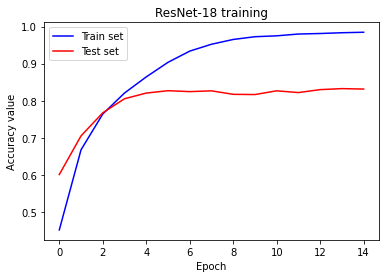

In [ ]:
plt.plot(np.arange(len(train_acc)), train_acc, color = 'blue')
plt.plot(np.arange(len(test_acc)), test_acc, color = 'red')
plt.legend(['Train set', 'Test set'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy value')
plt.title('ResNet-18 training')
plt.show()

In [ ]:
torch.save(res_net_18.state_dict(), './res_net_18.model')

## ResNet 34

Będę trenować na podzbiorze danych treningowych dla oszczędności czasu - na pełnym zbiorze jedna epoka zajmuje ponad 10 min

In [ ]:
from sklearn.model_selection import train_test_split

indices = np.arange(len(train_set))
train_indices, _ = train_test_split(indices, train_size=0.6, stratify=train_set.targets)

In [ ]:
len(train_indices)

30000

In [ ]:
train_dataset = torch.utils.data.Subset(train_set, train_indices)
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, num_workers=2, batch_size=10)

In [ ]:
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, num_workers=2, batch_size=10)

In [ ]:
def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

In [ ]:
res_net_34 = ResNet34().to(DEVICE)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(res_net_34.parameters(), lr = 0.001)

In [ ]:
epochs = 15

In [ ]:
train_acc = []
test_acc = []

for epoch in range(epochs):
    correct_train = 0
    for batch in train_loader:     
        images = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        preds = res_net_34(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = preds.max(1)

        correct_train += predicted.eq(labels).sum().item()

    accuracy_train = correct_train / len(train_set.data)
    train_acc.append(accuracy_train)

    # test
    correct_test = 0

    for batch in test_loader:     
        images = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        preds = res_net_34(images)
        _, predicted = preds.max(1)
        correct_test += predicted.eq(labels).sum().item()

    accuracy_test = correct_test / len(test_set.data)
    test_acc.append(accuracy_test)

    print(f"Epoch: {epoch}, train accuracy: {accuracy_train}, test accuracy: {accuracy_test}")

Epoch: 0, train accuracy: 0.20906, test accuracy: 0.4725
Epoch: 1, train accuracy: 0.32806, test accuracy: 0.6112
Epoch: 2, train accuracy: 0.39368, test accuracy: 0.6833
Epoch: 3, train accuracy: 0.43936, test accuracy: 0.7244
Epoch: 4, train accuracy: 0.4723, test accuracy: 0.7563
Epoch: 5, train accuracy: 0.50088, test accuracy: 0.775
Epoch: 6, train accuracy: 0.52554, test accuracy: 0.7824
Epoch: 7, train accuracy: 0.54784, test accuracy: 0.7788
Epoch: 8, train accuracy: 0.56344, test accuracy: 0.7836
Epoch: 9, train accuracy: 0.57238, test accuracy: 0.7804
Epoch: 10, train accuracy: 0.5782, test accuracy: 0.7824
Epoch: 11, train accuracy: 0.58066, test accuracy: 0.7874
Epoch: 12, train accuracy: 0.5842, test accuracy: 0.7828
Epoch: 13, train accuracy: 0.58554, test accuracy: 0.7803
Epoch: 14, train accuracy: 0.58742, test accuracy: 0.7766


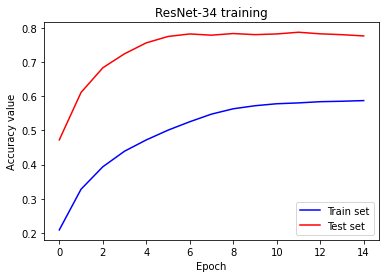

In [ ]:
plt.plot(np.arange(len(train_acc)), train_acc, color = 'blue')
plt.plot(np.arange(len(test_acc)), test_acc, color = 'red')
plt.legend(['Train set', 'Test set'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy value')
plt.title('ResNet-34 training')
plt.show()

In [ ]:
torch.save(res_net_34.state_dict(), './res_net_34.model')

Porównanie wyników ResNet18 i ResNet34

| Sieć | Rozmiar zbioru treningowego | Acuuracy na zbiorze treningowym | Rozmiar zbioru testowego | Accuracy na zbiorze testowym
|--------:|--------:|--------:|--------:|--------:|
| ResNet18 | 50000 | 0.9846 | 10000 | 0.8314 |
| ResNet34 | 30000 | 0.58742 | 10000 | 0.7766 |

W przypadku sieci ResNet18 doszło do overfittingu - wynik na zbiorze testowym jest znacznie wyższy niż na treningowym.

Sieć ResNet34 potrzebowała znacznie więcej czasu na wytrenowanie (dlatego była trenowana na podzbiorze zbioru treningowego). W jej przypadku nie doszło do overfittingu, a wynik na zbiorze testowym jest znacznie lepszy niż na zbiorze treningowym - zatem sieć dobrze uogólniła problem. Ponadto, wynik na zbiorze testowym jest porównywalny z wynikiem ResNet18.


## Trenowanie ResNet 18 z Dropoutem

Źródło funkcji wstawiającej dropouty: https://discuss.pytorch.org/t/where-and-how-to-add-dropout-in-resnet18/12869/2

In [1]:
# druga część notatnika - ponowne importowanie bibliotek i ponowna definicja klas

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if torch.cuda.is_available():  
    DEVICE = "cuda:0" 
else:  
    DEVICE = "cpu"

train_set = torchvision.datasets.CIFAR10(
    root = './data/CIFAR10',
    train = True,
    download = True,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()                                 
    ])
)

test_set = torchvision.datasets.CIFAR10(
    root = './data/CIFAR10',
    train = False,
    download = True,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()                                 
    ])
)

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, num_workers=2, batch_size=10)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, num_workers=2, batch_size=10)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def ResNet18_dropouts(rate):
    model = ResNet18()
    def append_dropout(model, rate=rate):
        for name, module in model.named_children():
            if len(list(module.children())) > 0:
                append_dropout(module)
            if isinstance(module, nn.ReLU):
                new = nn.Sequential(module, nn.Dropout2d(p=rate, inplace=True))
                setattr(model, name, new)
    append_dropout(model)
    return model

In [4]:
res_net_18_drop = ResNet18_dropouts(rate = 0.7).to(DEVICE)

In [5]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(res_net_18_drop.parameters(), lr = 0.001)

In [6]:
epochs = 15

In [7]:
train_acc = []
test_acc = []

for epoch in range(epochs):
    res_net_18_drop.train()
    correct_train = 0
    for batch in train_loader:     
        images = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        preds = res_net_18_drop(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = preds.max(1)

        correct_train += predicted.eq(labels).sum().item()

    accuracy_train = correct_train / len(train_set.data)
    train_acc.append(accuracy_train)

    # test
    res_net_18_drop.eval()
    correct_test = 0

    for batch in test_loader:     
        images = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        preds = res_net_18_drop(images)
        _, predicted = preds.max(1)
        correct_test += predicted.eq(labels).sum().item()

    accuracy_test = correct_test / len(test_set.data)
    test_acc.append(accuracy_test)

    print(f"Epoch: {epoch}, train accuracy: {accuracy_train}, test accuracy: {accuracy_test}")

Epoch: 0, train accuracy: 0.4777, test accuracy: 0.5949
Epoch: 1, train accuracy: 0.68892, test accuracy: 0.7634
Epoch: 2, train accuracy: 0.77966, test accuracy: 0.78
Epoch: 3, train accuracy: 0.83326, test accuracy: 0.8253
Epoch: 4, train accuracy: 0.87244, test accuracy: 0.8379
Epoch: 5, train accuracy: 0.9087, test accuracy: 0.837
Epoch: 6, train accuracy: 0.93616, test accuracy: 0.8379
Epoch: 7, train accuracy: 0.95458, test accuracy: 0.8378
Epoch: 8, train accuracy: 0.96686, test accuracy: 0.8394
Epoch: 9, train accuracy: 0.97204, test accuracy: 0.8395
Epoch: 10, train accuracy: 0.9776, test accuracy: 0.8368
Epoch: 11, train accuracy: 0.9796, test accuracy: 0.8384
Epoch: 12, train accuracy: 0.98126, test accuracy: 0.8349
Epoch: 13, train accuracy: 0.98312, test accuracy: 0.8472
Epoch: 14, train accuracy: 0.9846, test accuracy: 0.8431


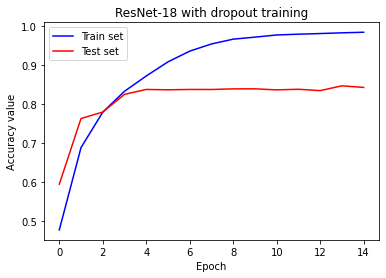

In [8]:
plt.plot(np.arange(len(train_acc)), train_acc, color = 'blue')
plt.plot(np.arange(len(test_acc)), test_acc, color = 'red')
plt.legend(['Train set', 'Test set'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy value')
plt.title('ResNet-18 with dropout training')
plt.show()

In [11]:
torch.save(res_net_18_drop.state_dict(), './res_net_18_drop.model')

Jak widać powyżej, pomimo użycia dość dużej wartości dropoutu, nastąpił overfitting. 

Niemniej jednak, trenowanie tej sieci trwało najkrócej i wynik na zbiorze testowym jest najwyższy.

## Macierz konfuzji

Do zaprezentowania macierzy konfuzji użyję ostatniego modelu - wytrenowanego z dropoutem

In [24]:
res_net_18_drop.eval()

y_hat = []
y_test = []

for batch in test_loader:     
    images = batch[0].to(DEVICE)
    labels = batch[1].to(DEVICE)
    preds = res_net_18_drop(images)
    _, predicted = preds.max(1)
    y_hat += predicted.tolist()
    y_test += labels.tolist()

In [25]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [32]:
y_hat_classes = list(map(lambda x: classes[x], y_hat))
y_test_classes = list(map(lambda x: classes[x], y_test))

<Figure size 864x576 with 0 Axes>

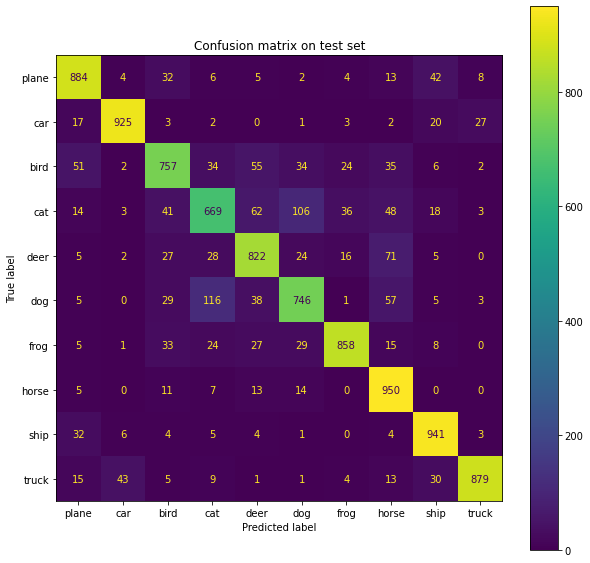

In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.title('Confusion matrix on test set')
plt.show()

Jak widać ma wykresie powyżej, model najczęściej mylił kota z psem - taki wynik był oczekiwany. Spośród rzeczy, które znajdują się na obrazkach, koty i psy są najbardziej podobne.

Spójrzmy zatem na przykład takiej pomyłki

In [50]:
wrongs = []
for i in range(len(y_hat_classes)):
    if y_hat_classes[i] == 'cat' and y_test_classes[i] == 'dog':
        wrongs.append(i)

In [51]:
len(wrongs)

116

In [85]:
def find_image_by_index(set_load, ind):
    loader = torch.utils.data.DataLoader(set_load, shuffle=False, num_workers=2, batch_size=1)
    current = 0
    for batch in loader:     
        if current == ind:
            searched = batch
            break
        else:
            current += 1
    return searched[0][0,:,:,:]

In [103]:
def show_img(idx):
    plt.title('Dog classified as a cat')
    plt.axis("off")
    plt.imshow(find_image_by_index(test_set, wrongs[idx]).permute(1, 2, 0))
    plt.show()

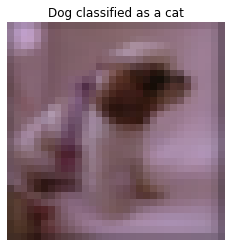

In [107]:
show_img(3)

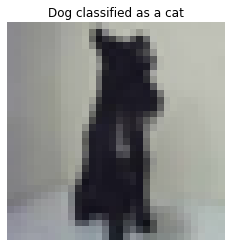

In [108]:
show_img(5)

Patrząc na dwa powyższe obrazki, faktycznie trudno jest stwierdzić, czy na obrazku jest pies czy kot. Zdjęcia są słabej rozdzielczości i, gdyby nie drobne detale (oczywiste do domyślenia się dla człowieka - długość kufy i uszu), również mielibyśmy problem z rozpoznaniem.

## DODATEK - sprawdzę, jak model zaklasyfikuje zdjęcie mojego psa

In [109]:
import skimage.io

image = skimage.io.imread(fname="pies.JPG")

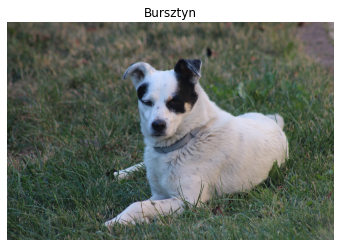

In [111]:
plt.imshow(image)
plt.title('Bursztyn')
plt.axis("off")
plt.show()

In [115]:
image.shape

(3456, 5184, 3)

In [116]:
# przeskalowanie obrazu
import skimage.transform

small = skimage.transform.resize(image=image, output_shape=(32, 32, 3))

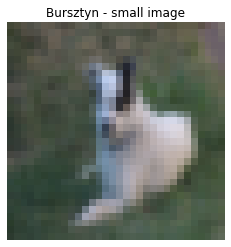

In [118]:
plt.imshow(small)
plt.title('Bursztyn - small image')
plt.axis("off")
plt.show()

In [120]:
small.shape

(32, 32, 3)

In [224]:
small_tens = torch.Tensor(small).permute(2, 0, 1)

In [137]:
small_tens[None, :].shape

torch.Size([1, 3, 32, 32])

In [147]:
pred = res_net_18_drop(small_tens[None, :].to(DEVICE))
_, predicted = pred.max(1)
predicted = predicted.tolist()[0]
classes[predicted]

'dog'

Udało się, mój pies to jednak pies :)

Mimo tego, że latem chodzi, jak kot, po parapecie :)

#### DODATEK - A czym będzie hipogryf znany z filmu o Harrym Potterze?

Źródło zdjęcia: https://thewizardingworld.co.uk/forums/topic/41562-35-things-you-might-not-know-about-harry-potter/

In [215]:
image_harry = skimage.io.imread(fname="https://images2.minutemediacdn.com/image/upload/c_fit,f_auto,fl_lossy,q_auto,w_728/v1556000677/shape/mentalfloss/5hk6jhk.png?itok=xTNtCT4N")

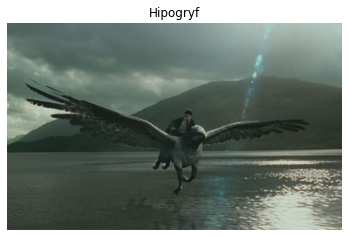

In [217]:
plt.imshow(image_harry)
plt.title('Hipogryf')
plt.axis("off")
plt.show()

In [218]:
image_harry.shape

(450, 727, 3)

In [219]:
small_harry = skimage.transform.resize(image=image_harry, output_shape=(32, 32, 3))

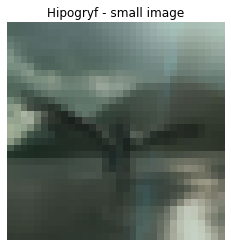

In [220]:
plt.imshow(small_harry)
plt.title('Hipogryf - small image')
plt.axis("off")
plt.show()

In [221]:
small_harry.shape

(32, 32, 3)

In [223]:
small_harry_tens = torch.Tensor(small_harry).permute(2, 0, 1)

In [225]:
pred = res_net_18_drop(small_harry_tens[None, :].to(DEVICE))
_, predicted = pred.max(1)
predicted = predicted.tolist()[0]
classes[predicted]

'plane'

Hipogryf jest samolotem, mimo że jest to zwierzę przypominające konia (ewentualnie jelenia) ze skrzydłami. 

Jednakże, trudno jest to dojrzeć na zdjęciu o tak małej rozdzielczości.

## WRACAJĄC DO TEMATU

## Wizualizacja wektora reprezentacji obrazów w podziale na klasy wykorzystując t-SNE

In [150]:
import copy

# 1. Kopia modelu
model_copy = copy.deepcopy(res_net_18_drop)

In [151]:
# 2. Zastąpienie ostatniej warstwy identycznością
model_copy.linear = nn.Identity(512)

Dla oszczędności czasu, wezmę 20% zbioru testowego do wizualizacji

In [197]:
# 3. Predykcje

from sklearn.model_selection import train_test_split

indices = np.arange(len(test_set))
test_indices, _ = train_test_split(indices, train_size=0.2, stratify=test_set.targets)
sub = torch.utils.data.Subset(train_set, test_indices)

outputs = np.empty((0, 512))
y_test = []

for batch in torch.utils.data.DataLoader(sub, shuffle=False, num_workers=2, batch_size=1):     
    images = batch[0].to(DEVICE)
    y_test += batch[1].tolist()
    out = model_copy(images).detach().cpu().numpy()[0].reshape(1, -1)
    outputs = np.concatenate([outputs, out], axis=0)

In [199]:
outputs.shape

(2000, 512)

In [198]:
len(y_test)

2000

In [212]:
# 4. PCA + TSNE

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

X_embedded = PCA(n_components=25).fit_transform(outputs)
X_embedded = TSNE().fit_transform(X_embedded)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


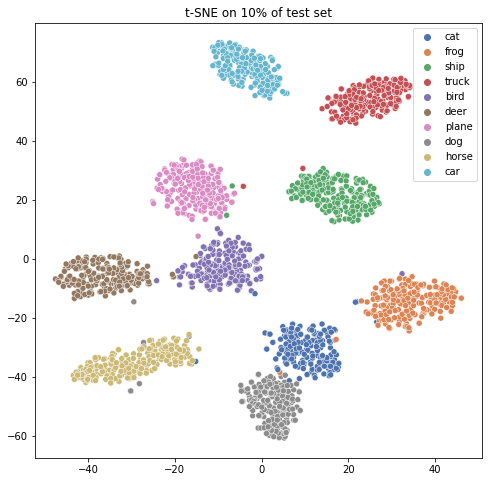

In [214]:
import seaborn as sns

plt.subplots(figsize=(8, 8))
sns.scatterplot(x = X_embedded[:, 0], y = X_embedded[:, 1], hue = list(map(lambda x: classes[x], y_test)), palette="deep")
plt.title('t-SNE on 10% of test set')
plt.show()

Jak widać na rysunku powyżej, powstały klastry odpowiadającej każdej z klas. 

Warto zauważyć to, że t-SNE również wykrył "bliskość" psów i kotów - z tego wynikają częste błędy sieci.

Ciekawą obserwacją jest również bliskie położenie trzech klas - ptaków, samolotów i jeleni. Jednakże, takie ułożenie wydaje się również logiczne. Ptaki i samoloty mają skrzydła, więc są pod tym względem do siebie podobne. Co tam robią jelenie? Możliwe, że sieć wzięła pod uwagę ich poroże.